In [25]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.svm import SVC
from sklearn.metrics import recall_score, fbeta_score


# Reading the dataset

In [2]:
df = pd.read_csv("Algerian_forest_fires_dataset.csv", header=1)
cols = ["day", "month", "year", "temperature", "rh", "ws", "rain", "ffmc", "dmc", "dc", "isi", "bui", "fwi", "classes"]
df.columns = cols
df.head()

,day,month,year,temperature,rh,ws,rain,ffmc,dmc,dc,isi,bui,fwi,classes
0,01,06,2012,29,57,18,0,65.7,3.4,7.6,1.3,3.4,0.5,not fire
1,02,06,2012,29,61,13,1.3,64.4,4.1,7.6,1,3.9,0.4,not fire
2,03,06,2012,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1,not fire
3,04,06,2012,25,89,13,2.5,28.6,1.3,6.9,0,1.7,0,not fire
4,05,06,2012,27,77,16,0,64.8,3,14.2,1.2,3.9,0.5,not fire


# Data Cleaning

In [3]:
df[df.isna().any(axis=1)]

,day,month,year,temperature,rh,ws,rain,ffmc,dmc,dc,isi,bui,fwi,classes
122,Sidi-Bel Abbes Region Dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
167,14,07,2012,37,37,18,0.2,88.9,12.9,14.6 9,12.5,10.4,fire,NaN


In [4]:
df = df.dropna(axis=0)
df = df.drop(index=df[df.temperature == "Temperature"].index)
float_cols = ["temperature", "rh", "ws", "rain", "ffmc", "dmc", "dc", "isi", "bui", "fwi"]
df[float_cols] = df[float_cols].astype(np.float32)
df[["day", "month", "year"]] = df[["day", "month", "year"]].astype(np.int32)
df["classes"] = df["classes"].str.strip(" ")

In [5]:
df["classes"].value_counts()

classes
fire        137
not fire    106
Name: count, dtype: int64

In [6]:
df.describe()

,day,month,year,temperature,rh,ws,rain,ffmc,dmc,dc,isi,bui,fwi
count,243.000000,243.000000,243.0,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000
mean,15.761317,7.502058,2012.0,32.152264,62.041153,15.493827,0.762963,77.842384,14.680658,49.430866,4.742387,16.690535,7.035390
std,8.842552,1.114793,0.0,3.628039,14.828160,2.811385,2.003207,14.349641,12.393040,47.665607,4.154234,14.228421,7.440568
min,1.000000,6.000000,2012.0,22.000000,21.000000,6.000000,0.000000,28.600000,0.700000,6.900000,0.000000,1.100000,0.000000
25%,8.000000,7.000000,2012.0,30.000000,52.500000,14.000000,0.000000,71.850002,5.800000,12.350000,1.400000,6.000000,0.700000
50%,16.000000,8.000000,2012.0,32.000000,63.000000,15.000000,0.000000,83.300003,11.300000,33.099998,3.500000,12.400000,4.200000
75%,23.000000,8.000000,2012.0,35.000000,73.500000,17.000000,0.500000,88.300003,20.800000,69.099998,7.250000,22.650000,11.450000
max,31.000000,9.000000,2012.0,42.000000,90.000000,29.000000,16.799999,96.000000,65.900002,220.399994,19.000000,68.000000,31.100000


In [7]:
df.groupby("classes").max()

,day,month,year,temperature,rh,ws,rain,ffmc,dmc,dc,isi,bui,fwi
classes,,,,,,,,,,,,,
fire,31,9,2012,42.0,88.0,21.0,6.000000,96.0,65.900002,220.399994,19.0,68.000000,31.1
not fire,31,9,2012,39.0,90.0,29.0,16.799999,82.0,37.000000,180.399994,3.0,37.400002,6.1


# Creating Data Training dan Testing

In [8]:
fire_rows = df[df["classes"] == "fire"]
df["classes"] = df["classes"].replace(["fire", "not fire"], [0, 1])

In [9]:
y = df["classes"]
x = df[["temperature", "rh", "ws", "rain", "dmc"]]

In [10]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=83)

In [11]:
scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [12]:
y_train.value_counts()

classes
0    98
1    72
Name: count, dtype: int64

In [13]:
y_test.value_counts()

classes
0    39
1    34
Name: count, dtype: int64

# Model Machine Learning

### Model 1. ANN

In [14]:
regularizer = tf.keras.regularizers.l2(0.001)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=25,
                                            verbose=0,
                                            restore_best_weights=True)
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(8, input_shape=(x_train.shape[1],)),
    tf.keras.layers.Dense(32, kernel_regularizer=regularizer),
    tf.keras.layers.Dense(32, kernel_regularizer=regularizer),
    tf.keras.layers.Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy",
            optimizer='adam',
            metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 48        
                                                                 
 dense_1 (Dense)             (None, 32)                288       
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,425
Trainable params: 1,425
Non-trainable params: 0
_________________________________________________________________


In [15]:
history = model.fit(x_train_scaled, y_train.values,
                    validation_data=(x_test_scaled, y_test.values),
                    epochs=1000,
                    callbacks=[callback],
                    verbose=0)
print("Best number of epoch:", callback.best_epoch)

Best number of epoch: 99


Training data loss value: 0.3860643804073334
Testing data loss value: 0.3353766202926636


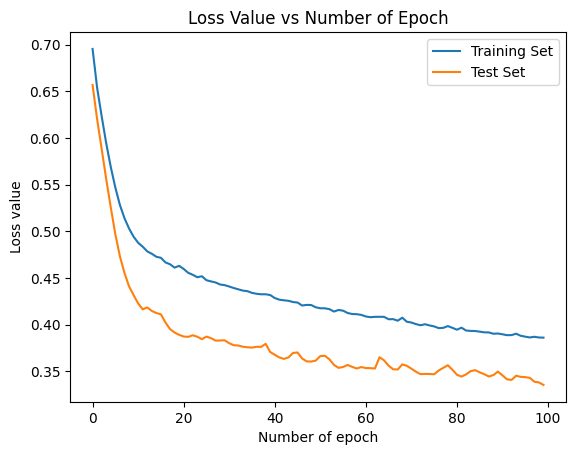

In [17]:
print("Training data loss value:", history.history['loss'][callback.best_epoch])
print("Testing data loss value:", history.history["val_loss"][callback.best_epoch])
plt.plot(history.history['loss'][:callback.best_epoch+1])
plt.plot(history.history['val_loss'][:callback.best_epoch+1])
plt.title('Loss Value vs Number of Epoch')
plt.ylabel('Loss value')
plt.xlabel('Number of epoch')
plt.legend(['Training Set', 'Test Set'], loc='upper right')
plt.show()

Training data accuracy: 86.47 %
Testing data accuracy: 84.93 %


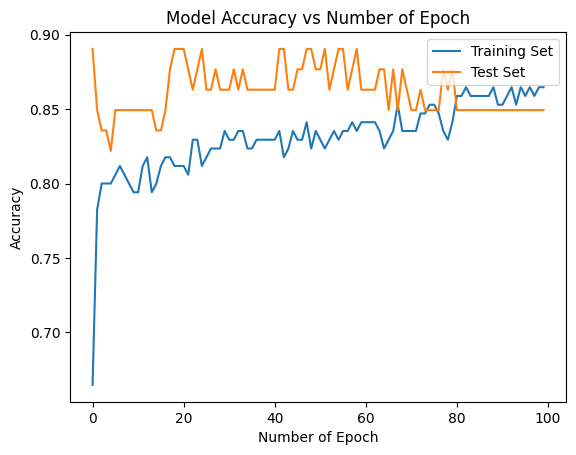

In [18]:
print("Training data accuracy:", round(history.history['accuracy'][callback.best_epoch]*100, 2), "%")
print("Testing data accuracy:", round(history.history['val_accuracy'][callback.best_epoch]*100, 2), "%")
plt.plot(history.history['accuracy'][:callback.best_epoch+1])
plt.plot(history.history['val_accuracy'][:callback.best_epoch+1])
plt.title('Model Accuracy vs Number of Epoch')
plt.ylabel('Accuracy')
plt.xlabel('Number of Epoch')
plt.legend(['Training Set', 'Test Set'], loc='upper right')
plt.show()

In [19]:
y_pred = model.predict(x_test_scaled)
y_pred[y_pred <= 0.5] = 0.
y_pred[y_pred > 0.5] = 1.
confusion_matrix(y_test.values, y_pred)

3/3 [==============================] - 1s 3ms/step


array([[35,  4],
       [ 7, 27]], dtype=int64)

### Model 2. Random Forest

In [20]:
clf_forest = RandomForestClassifier(max_depth=1, random_state=83)
clf_forest.fit(x_train_scaled, y_train)
print("Training and test data accuracy:")
print(clf_forest.score(x_train_scaled, y_train), clf_forest.score(x_test_scaled, y_test))

Training and test data accuracy:
0.888235294117647 0.8493150684931506


In [21]:
print("Confusion matrix:")
print(confusion_matrix(clf_forest.predict(x_test_scaled), y_test.values))

Confusion matrix:
[[37  9]
 [ 2 25]]


### Model 3. RBF SVM

In [23]:
clf_svm = SVC(C=1, random_state=83)
clf_svm.fit(x_train_scaled, y_train)
print("Training and test data accuracy:")
print(clf_svm.score(x_train_scaled, y_train), clf_svm.score(x_test_scaled, y_test))

Training and test data accuracy:
0.888235294117647 0.8493150684931506


In [24]:
print("Confusion matrix:")
print(confusion_matrix(clf_svm.predict(x_test_scaled), y_test.values))

Confusion matrix:
[[36  8]
 [ 3 26]]


In [43]:
recall_scores = [recall_score(y_test, y_pred), 
                 recall_score(y_test, clf_forest.predict(x_test_scaled)),
                 recall_score(y_test, clf_svm.predict(x_test_scaled))]
fbeta_scores =  [fbeta_score(y_test, y_pred, beta=2.), 
                 fbeta_score(y_test, clf_forest.predict(x_test_scaled), beta=2.),
                 fbeta_score(y_test, clf_svm.predict(x_test_scaled), beta=2.)]
models = ['ANN', 'Random Forest', 'SVM']

for i, model_name in enumerate(models):
    print(f"{model_name} recall value: {recall_scores[i]}")
    print(f"{model_name} F-{2} score: {fbeta_scores[i]}")
    print("---")
print("\nBest model:", models[np.argmax(fbeta_scores)])

ANN recall value: 0.7941176470588235
ANN F-2 score: 0.808383233532934
---
Random Forest recall value: 0.7352941176470589
Random Forest F-2 score: 0.7668711656441719
---
SVM recall value: 0.7647058823529411
SVM F-2 score: 0.7878787878787877
---

Best model: ANN


# Data Prediction from Another Dataset

In [44]:
df_test = pd.read_csv("test - 14052023.csv")
df_test.head()

,name,time,current,geohash,humid,soilHumid,speedWind,temp,voltage,waterLevel,windDirection
0,GW28,1679714236294000000,76.929,qrvz851e,65,1,0,28.5,8.376,0,0
1,GW28,1679714537379000000,75.830,qrvz851e,68,1,0,28.9,8.019,0,0
2,GW28,1679714838093000000,76.630,qrvz851e,60,1,0,31.3,8.255,0,0
3,GW28,1679715138457000000,75.403,qrvz851e,56,1,0,34.2,8.099,0,0
4,GW28,1679715438669000000,76.306,qrvz851e,50,1,0,36.3,8.184,0,0


In [45]:
df_test = df_test.drop(df_test[df_test["temp"] == 0].index, axis=0) # drop null datas (temperature = 0)
df_test  = df_test.drop(df_test[df_test["time"] < 1681102799000000000].index, axis=0) # drop old datas
df_test.head()

,name,time,current,geohash,humid,soilHumid,speedWind,temp,voltage,waterLevel,windDirection
87,GW28,1681184160712000000,84.827,qrvz851e,50,2,0,31.8,7.673,0,0
88,GW28,1681184441228000000,86.731,qrvz851e,47,2,0,32.3,7.670,0,0
89,GW28,1681184721769000000,86.053,qrvz851e,45,2,0,33.3,7.671,0,0
90,GW28,1681185002371000000,86.005,qrvz851e,45,2,0,33.3,7.671,0,0
91,GW28,1681185282896000000,85.101,qrvz851e,46,2,0,32.3,7.670,0,0


In [46]:
x_indo = df_test[["temp", "humid", "speedWind", "waterLevel", "soilHumid"]]
x_indo = x_indo.rename(columns={"temp":"temperature", "humid":"rh", "speedWind":"ws", "waterLevel":"rain", "soilHumid":"dmc"})

In [53]:
x_indo_scaled = scaler.transform(x_indo)
result = clf_forest.predict(x_indo_scaled)
actual = np.array([1 for _ in range(result.shape[0])])

In [52]:
result_tf = model.predict(x_indo_scaled)
result_tf[result_tf < 0.5] = 0.
result_tf[result_tf >= 0.5] = 1.

211/211 [==============================] - 0s 2ms/step


In [55]:
print(f"Accuracy: {round(100 * np.where(result_tf == 1)[0].shape[0] / result_tf.shape[0], 2)}%")

Accuracy: 98.9%


In [56]:
print(np.where(result_tf == 1)[0].shape[0], "datas from", result_tf.shape[0], "datas are perfectly classified")

6660 datas from 6734 datas are perfectly classified


In [57]:
np.savetxt("scaler_scale.txt", scaler.scale_)
np.savetxt("scaler_min.txt", scaler.min_)

In [58]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
  f.write(tflite_model)